# Installation instructions

```julia
pkg> dev https://github.com/JuliaReach/NeuralNetworkAnalysis.jl

# other dependencies for this notebook
pkg> add Plots DifferentialEquations
```

In [ ]:
using NeuralNetworkAnalysis
import Plots, DifferentialEquations, DisplayAs
using Plots: plot, plot!, lens!, bbox

# Introduction

`NeuralNetworkAnalysis` is a new package in the JuliaReach family. The aim is (currently) to analyze **neural-network control systems (NNCS)**, that is, *plant models* (dynamical systems) that receive inputs from a *controller*, which in this case is a *neural network*. We assume that the dynamical system is given as an ordinary differential equation (ODE) and the neural network is accessible as a white box.

Below is a schematic view:

<div>
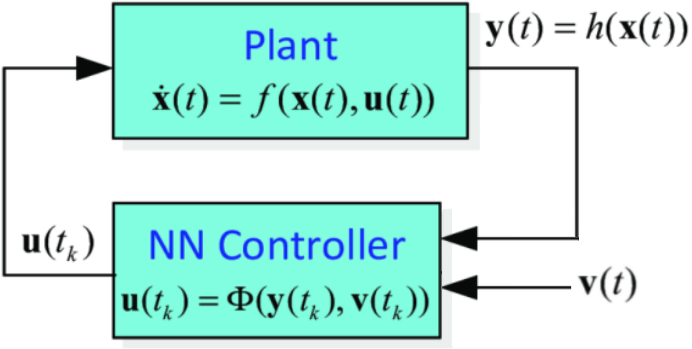
</div>

##### Main features

- Simulation for NNCS

- Set propagation for NNCS, in sound or approximate ways

##### Supported systems

- nonlinear ODEs $f$ with states $x$ (tested with up to 12 dimensions) and control inputs $u$ (tested with up to 6 dimensions)

- feedforward neural networks $\Phi$ (tested with up to 5 hidden layers of up to 500 neurons each) with ReLU activation functions

##### Builds on

- [`ReachabilityAnalysis`](https://github.com/JuliaReach/ReachabilityAnalysis.jl) for set propagation through the ODE

- [`NeuralVerification`](https://github.com/sisl/NeuralVerification.jl) for set propagation through the neural network (uses `LazySets`)


`NeuralNetworkAnalysis` originated as a participant in a friendly competition of research tools to analyze NNCS ([ARCH-COMP 2021](https://cps-vo.org/group/ARCH/FriendlyCompetition)). Our plan was to just put these two black-box tools together. But doing this in a naive way results in an unsatisfactorily conservative precision. We will not go into the technical details, but the package uses some tricks to finally be able to either verify or falsify all benchmark problems.

# Example: Unicycle model

We consider a model of a single wheel of a car that is described by the $x$ and $y$ coordinates ($x_1, x_2$), the velocity ($x_3$), and the steering angle ($x_4$). The controller sends two control inputs to influence the angle ($u_1$) and the velocity ($u_2$). The position evolves according to velocity and angle. We also assume that there is a disturbance ($w$).

## Modeling the NNCS

The plant ODE looks as follows:

$$
\begin{align*}
    \dot{x}_1 &= x_4 \cos(x_3) \tag{$x$ position} \\
    \dot{x}_2 &= x_4 \sin(x_3) \tag{$y$ position} \\
    \dot{x}_3 &= u_2 \tag{velocity} \\
    \dot{x}_4 &= u_1 + w \tag{steering angle}
\end{align*}
$$

In [ ]:
@taylorize function unicycle!(dx, x, p, t)
    x₁, x₂, x₃, x₄, w, u₁, u₂ = x

    dx[1] = x₄ * cos(x₃)
    dx[2] = x₄ * sin(x₃)
    dx[3] = u₂
    dx[4] = u₁ + w
    dx[5] = zero(x[5])  # model w as a constant
    dx[6] = zero(x[6])
    dx[7] = zero(x[7])
    return dx
end

The neural-network controller is pre-trained and has one hidden layer with 500 neurons. The network is available as a `.mat` file [here](https://github.com/JuliaReach/NeuralNetworkAnalysis.jl/blob/master/models/Sherlock-Benchmark-10-Unicycle/controllerB_nnv.mat).

In [ ]:
controller = read_nnet_mat(@modelpath("", "controllerB_nnv.mat"); act_key="act_fcns");

The output of the network needs to be normalized by subtracting $20$ from each coordinate (i.e., $(u_1, u_2)^T = \Phi(y, w) - (20, 20)^T$ following the notation from the schematic picture).

In [ ]:
control_postprocessing = NeuralNetworkAnalysis.UniformAdditivePostprocessing(-20.0);

Time is measured in seconds and the controller acts periodically with sampling time $0.2$ seconds.

In [ ]:
period = 0.2;

The initial condition is

$$
x_1 \in [9.5, 9.55],~~
x_2 \in [-4.5, -4.45],~~
x_3 \in [2.1, 2.11],~~
x_4 \in [1.5, 1.51],~~
w \in [-0.0001, 0.0001]
$$


In [ ]:
X₀ = Hyperrectangle(low=[ 9.5,  -4.5,  2.1,  1.5, -1e-4],
                    high=[9.55, -4.45, 2.11, 1.51, 1e-4]);

The initial-value problem (IVP) is the ODE together with the initial condition.

In [ ]:
U₀ = ZeroSet(2)  # can be any two-dimensional set because it will be ignored
ivp = @ivp(x' = unicycle!(x), dim: 7, x(0) ∈ X₀ × U₀);

The control system is wrapped in a `ControlledPlant` struct:

In [ ]:
# mapping from dimensions to type of variables (states, uncertain inputs, control inputs)
vars_idx = Dict(:state_vars=>1:4, :input_vars=>[5], :control_vars=>6:7)

# system consisting of a plant and a controller
nncs = ControlledPlant(ivp, controller, vars_idx, period; postprocessing=control_postprocessing);

The specification is that all trajectories of the system satisfy the conditions

$$
x_1 \in [-0.6, 0.6],~~
x_2 \in [-0.2, 0.2],~~
x_3 \in [-0.06],~~
x_4 \in [-0.3]
$$

at the time point when $10$ seconds have passed.

In [ ]:
using NeuralNetworkAnalysis: SingleEntryVector  # a sparse vector type with a single non-zero entry from LazySets

# target set to be reached
target_set = HPolyhedron([HalfSpace(SingleEntryVector(1, 7, 1.0), 0.6),
                          HalfSpace(SingleEntryVector(1, 7, -1.0), 0.6),
                          HalfSpace(SingleEntryVector(2, 7, 1.0), 0.2),
                          HalfSpace(SingleEntryVector(2, 7, -1.0), 0.2),
                          HalfSpace(SingleEntryVector(3, 7, 1.0), 0.06),
                          HalfSpace(SingleEntryVector(3, 7, -1.0), 0.06),
                          HalfSpace(SingleEntryVector(4, 7, 1.0), 0.3),
                          HalfSpace(SingleEntryVector(4, 7, -1.0), 0.3)])

# time horizon
T = 10.0

# predicate to check the specification for a flowpipe
function spec(flowpipe)
    R = flowpipe[end]  # obtain the last reach set
    @assert T ∈ tspan(R)  # sanity check: the last reach set covers time T
    return R ⊆ target_set  # check that the last reach set is contained in the target set
end;

## Simulation of the NNCS

We can simulate a single trajectory of the NNCS from a random initial point.

In [ ]:
sim = simulate(nncs, T=T; trajectories=1);

Below we plot the projection in dimensions $x_1$ and $x_2$. First we plot the initial set and the target set.

In [ ]:
p = plot(project(X₀, [1, 2]), lab="X₀", xlab="x1", ylab="x2")
plot!(p, project(target_set, [1, 2]), lab="target")
DisplayAs.Text(DisplayAs.PNG(p))

<img src="pics/nna_1.png" alt="Drawing" style="width: 600px;"/>

Next we add the simulation. We do not yet have a plot recipe, so plotting works via the custom `plot_simulation!` function.

Zooming in on the initial and target sets we see that the trajectory satisfies the specification.

In [ ]:
plot_simulation!(p, sim; vars=[1, 2], color=:black, lab="")
lens!(p, [9.45, 9.6], [-4.55, -4.4], inset = (1, bbox(0.7, 0.2, 0.3, 0.25)))
lens!(p, [0.3, 0.7], [-0.3, 0.3], inset = (1, bbox(0.1, 0.3, 0.3, 0.3)))
DisplayAs.Text(DisplayAs.PNG(p))

<img src="pics/nna_2.png" alt="Drawing" style="width: 600px;"/>

We shoul also look at the projection in dimensions $x_3$ and $x_4$. First we write a helper function for plotting consistently.

In [ ]:
# helper function for plotting simulations
function plot_sim!(p, sim, vars)
    plot_simulation!(p, sim; vars=vars, color=:black, lab="")
end

# custom limits and zoom depending on the projection
function plot_zoom!(p, vars)
    if vars == [1, 2]
        lens!(p, [9.45, 9.6], [-4.55, -4.4], inset = (1, bbox(0.7, 0.2, 0.3, 0.25)))
        lens!(p, [0.3, 0.7], [-0.3, 0.3], inset = (1, bbox(0.1, 0.3, 0.3, 0.3)))
    elseif vars == [3, 4]
        plot!(xlims=[-0.2, 2.7], ylims=[-1.5, 3], leg=:topleft)
        lens!(p, [2.095, 2.12], [1.49, 1.52], inset = (1, bbox(0.4, 0.1, 0.3, 0.3)))
        lens!(p, [-0.1, 0.1], [-0.5, -0.1], inset = (1, bbox(0.6, 0.6, 0.3, 0.3)))
    end
end

# helper function for plotting everything
function plot_all(sim, vars)
    p = plot(xlab="x$(vars[1])", ylab="x$(vars[2])")
    plot!(p, project(X₀, vars), lab="X₀")
    plot!(p, project(target_set, vars), lab="target")

    plot_sim!(p, sim, vars)
    plot_zoom!(p, vars)
    return p
end;

In [ ]:
p = plot_all(sim, [3, 4])
DisplayAs.Text(DisplayAs.PNG(p))

<img src="pics/nna_3.png" alt="Drawing" style="width: 600px;"/>

But does the specification hold for *all* trajectories? Let us try 3 random trajectories plus those emerging from the 16 vertices of $X_0$.

In [ ]:
sim = simulate(nncs, T=T; trajectories=3, include_vertices=true)
@show length(sim);

Plotting these will take a while because the plot support is not efficient yet.

In [ ]:
p = plot_all(sim, [1, 2])
DisplayAs.Text(DisplayAs.PNG(p))

<img src="pics/nna_4.png" alt="Drawing" style="width: 600px;"/>

In [ ]:
p = plot_all(sim, [3, 4])
DisplayAs.Text(DisplayAs.PNG(p))

<img src="pics/nna_5.png" alt="Drawing" style="width: 600px;"/>

So it looks like the specification may hold. But this is really not a proof. We need to use reachability analysis.

## Reachability analysis

First we extend our helper function for additionally plotting the flowpipe.

In [ ]:
function plot_sol!(p, sol, vars)
    plot!(p, sol, vars=vars, c=:orange)
end

function plot_all(sol, sim, vars)
    p = plot(xlab="x$(vars[1])", ylab="x$(vars[2])")
    plot!(p, project(X₀, vars), lab="X₀")
    plot!(p, project(target_set, vars), lab="target")

    plot_sol!(p, sol, vars)
    plot_sim!(p, sim, vars)
    plot_zoom!(p, vars)
    return p
end;

### First attempt

Below we use the standard `solve`, which will be good but overall too coarse to prove the desired property.

In [ ]:
alg = TMJets(abstol=1e-15, orderT=10, orderQ=1)
alg_nn = Ai2();

In [ ]:
@time sol = solve(nncs, T=T, alg_nn=alg_nn, alg=alg);

The specification cannot be proven.

In [ ]:
spec(sol)

Plotting the results (for which we go back to one simulation because it plots faster).

In [ ]:
sim = simulate(nncs, T=T; trajectories=1);

In [ ]:
p = plot_all(sol, sim, [1, 2])
DisplayAs.Text(DisplayAs.PNG(p))

<img src="pics/nna_6.png" alt="Drawing" style="width: 600px;"/>

In [ ]:
p = plot_all(sol, sim, [3, 4])
DisplayAs.Text(DisplayAs.PNG(p))

<img src="pics/nna_7.png" alt="Drawing" style="width: 600px;"/>

### Splitting the initial condition

Ultimately the problem with precision comes from losing dependencies when switching between the plant and the controller. We can mitigate by starting from a smaller subset of the initial condition. For example, we can split the initial condition in half and then consider the union of two solutions. In this case we can show the property when splitting into 24 pieces.

In [ ]:
splitter = BoxSplitter([3, 1, 8, 1]);  # split into uniform boxes in dimensions 1 and 3

In [ ]:
@time sol2 = solve(nncs, T=T, alg_nn=alg_nn, alg=alg, splitter=splitter);

In [ ]:
spec(sol2)

In [ ]:
p = plot_all(sol2, sim, [1, 2])
DisplayAs.Text(DisplayAs.PNG(p))

<img src="pics/nna_8.png" alt="Drawing" style="width: 600px;"/>

In [ ]:
p = plot_all(sol2, sim, [3, 4])
DisplayAs.Text(DisplayAs.PNG(p))

<img src="pics/nna_9.png" alt="Drawing" style="width: 600px;"/>